# Hazard Assessment for Wildfire - Machine Learning Approach

Click  [![Fire](https://img.shields.io/badge/FIRE-repository-orange)](https://github.com/CLIMAAX/FIRE)  to go to this workflow's GitHub repository.

Contributors:

- Andrea Trucchia (Andrea.trucchia@cimafoundation.org)
- Farzad Ghasemiazma (Farzad.ghasemiazma@cimafoundation.org)
- Giorgio Meschi (Giorgio.meschi@cimafoundation.org)

This Jupyter Notebook is used to compute a Hazard map for an interested area using these inputs: DEM, Corine land-cover, Fire data, administrative level (NUTS).
Moreover, it is used to analyze fire hazard data and perform various preprocessing and analysis tasks.


## Introduction

In this section, an overview of the project and the goals of the analysis will be provided.
This analysis is based on the hazard mapping works of [Tonini et al. 2020](https://doi.org/10.3390/geosciences10030105), [Trucchia et al. 2023](https://doi.org/10.1071/WF22138).

The workflow is based on the following steps:

- Data gathering and preprocessing.
- Building a model for wildfire susceptibility using present climate conditions and synoptic wildfire events. 
- Projecting the model to future climate conditions. 
- For both cases, susceptibility can be evolved to hazard by considering the different plant functional types, which are a proxy for the intensity of potential wildfires. See [Trucchia et al. 2023](https://doi.org/10.1071/WF22138) for more details. 
- Damage assessment for different vulnearbility categories and exposed elements(roads) in order to get Risk maps.
- Regarding climate, the analysis revolves around a High-resolution gridded climate data for Europe based on bias-corrected EURO-CORDEX: the ECLIPS-2.0 dataset. ECLIPS (European CLimate Index ProjectionS) dataset contains gridded data for 80 annual, seasonal, and monthly climate variables for two past (1961-1990, 1991-2010) and five future periods (2011-2020, 2021-2140, 2041-2060, 2061-2080, 2081-2100). The future data are based on five Regional Climate Models (RCMs) driven by two greenhouse gas concentration scenarios, RCP 4.5 and 8.5. See [Debojyoti et al. 2020](https://doi.org/10.5281/zenodo.3952159) for more details.

## Preparation Work

At the present stage, the analysis case study is the **Catalonia** region in Spain.
A prepared [sample dataset](https://handbook.climaax.eu/resources/datasets/wildfire_sample_cat.html) for Catalonia is available from the CLIMAAX cloud storage.

:::{admonition} Assessing risk for other regions
:class: important

To assess the wildfire hazard and risk for a **different region**, data equivalent to the provided Catalonia sample have to be provided and substituted throughout the workflow.
This includes:

- A shapefile of the region (sample data in `data_cat/adm_level_stanford/`)
- Digital Elevation Model (DEM) raster data (sample data in `dem_processing/`)
- Land cover data (sample data from [CORINE](https://land.copernicus.eu/en/products/corine-land-cover) in `data_cat/hazard/input_hazard/`)
- A dataset of historical fires (sample data in `data_cat/hazard/input_hazard/fires/`)
- A climate dataset with parameters relating to fuel availability and fire danger (sample data based on [ECLIPS-2.0](https://doi.org/10.5281/zenodo.3952159) in `resized_climate/)`.
- Vulnerability data (sample data from [JRC](https://doi.org/10.2760/46951) with European coverage in `/data_cat/Vul_data/`; *risk assessment only*)
- Exposure data, e.g. for critical infrastructure (sample data in `data_cat/risk/`; *risk assessment only*)
- NUTS level data for aggregation (sample data for Spain in `data_cat/administrative_units_NUTS/`; *risk assessment only*)

To simplify the creation of the climate dataset for input in the machine learning model, CLIMAAX provides a (partial) [dataset mirror](https://handbook.climaax.eu/resources/datasets/eclips2.0_mirror.html) of relevant parameters from the ECLIPS-2.0 dataset.
For the purposes of this workflow, we recommend downloading the ECLIPS-2.0 data via this mirror, as the original dataset is only provided as a single 87.2 GB-large compressed archive file.
See below for options for obtaining the climate dataset.
:::

Most of the analysis is based on raster calculations. The "base" raster is a clipped dem file (`data_cat/hazard/input_hazard/dem_3035_clip.tif`), which has been clipped using the extent of the Catalonia administrative shapefile. The raster is metric, using the EPSG:3035 projection, with 100 meter resolution, and with extent (left, bottom, right, top) given by:

    3488731.355 1986586.650 3769731.355 2241986.650

### Import libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [os](https://docs.python.org/3/library/os.html): Provides functions for interacting with the operating system, such as file operations and environment variables.
- [pooch](https://www.fatiando.org/pooch/latest/index.html): To download data from various sources (Zenodo, CLIMAAX cloud storage)
- [rasterio](https://rasterio.readthedocs.io/en/stable/): A library for reading and writing geospatial raster datasets. It provides functionalities to work with raster data formats such as GeoTIFF and perform various raster operations.
- [tqdm](https://github.com/tqdm/tqdm): A fast, extensible progress bar for Python and CLI. It allows for easy visualization of loop progress and estimates remaining time.
- [matplotlib.pyplot](https://matplotlib.org/): Matplotlib's plotting interface, providing functions for creating and customizing plots. %matplotlib inline is an IPython magic command to display Matplotlib plots inline within the Jupyter Notebook or IPython console.
- [numpy](https://numpy.org/): A fundamental package for scientific computing with Python. It provides support for large multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- [gdal](https://gdal.org/): Python bindings for the Geospatial Data Abstraction Library (GDAL), used for reading and writing various raster geospatial data formats.
- [geopandas](https://geopandas.org/): Extends the Pandas library to support geometric operations on GeoDataFrames, allowing for easy manipulation and analysis of geospatial data.
- [pandas](https://pandas.pydata.org/): A powerful data manipulation and analysis library for Python. It provides data structures like DataFrame for tabular data and tools for reading and writing data from various file formats.
- [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html): Provides signal processing tools, including functions for filtering, spectral analysis, and convolution.
- [sklearn](https://scikit-learn.org/stable/): The scikit-learn library for machine learning in Python. It includes various algorithms for classification, regression, clustering, dimensionality reduction, and more. train_test_split is a function for splitting datasets into train and test sets, and RandomForestClassifier is an implementation of the Random Forest classifier algorithm.
:::

In [1]:
import os
import pathlib

import pooch
from tqdm import tqdm

import numpy as np
from osgeo import gdal, ogr
import geopandas as gpd
import pandas as pd
from scipy import signal
import rasterio
from rasterio import features
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.plot
from rasterio.mask import mask

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.patches as mpatches

### Path configuration

Paths to data for the layers used in the notebook (mostly rasters and shapefiles).

In [2]:
region_name = "cat" # example configuration: Catalonia

data_path = pathlib.Path(f"./data_{region_name}")
input_hazard_path = data_path / "hazard" / "input_hazard"
output_hazard_path = data_path / "hazard" / "output_hazard"
output_hazard_path.mkdir(parents=True, exist_ok=True)

dem_path = input_hazard_path / "dem2_3035.tif"
dem_path_clip = input_hazard_path / "dem_3035_clip.tif"

clc_path = input_hazard_path / "veg_corine_reclass.tif"
clc_path_clip = input_hazard_path / "veg_corine_reclass_clip.tif"
clc_path_clip_nb = input_hazard_path / "veg_corine_reclass_clip_nb.tif"
fires_raster_path = input_hazard_path / "fires_raster.tif"

region_adm_path = data_path / "adm_level_stanford" / "catalonia_adm_3035.shp"

dem_proc_path = pathlib.Path("./dem_processing")
slope_path = dem_proc_path / "slope.tif"
aspect_path = dem_proc_path / "aspect.tif"
easting_path = dem_proc_path / "easting.tif"
northing_path = dem_proc_path / "northing.tif"
roughness_path = dem_proc_path / "roughness.tif"

### Download Catalonia sample data

To run the workflow for the Catalonia region, a [sample input dataset](https://handbook.climaax.eu/resources/datasets/wildfire_sample_cat.html) is downloaded from the CLIMAAX cloud storage.
We will download all files here before continuing.
A registry for the data (about 1.3 GB total) that can be used by the pooch package is included with the workflow repository (`files_registry.txt`). We load it here and retrieve all listed files.
If any files were downloaded before, pooch will inspect the local file contents and skip the download if the contents match expectations.

The data is downloaded into three folders:

- `data_cat`
- `dem_processing`
- `resized_climate`

In [ ]:
# Make sure that path configuration is appropriate for example dataset
assert region_name == "cat"

# Pooch downloader for workflow directory and CLIMAAX cloud storage
sample_pooch = pooch.create(
    path=".",
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/wildfire_sample_cat/"
)
sample_pooch.load_registry("files_registry_cat.txt")

# Download all files from the attached registry
for path in sample_pooch.registry:
    sample_pooch.fetch(path)

## ECLIPS-2.0 dataset

To overlay wildfire polygons with climate data, and to perform future projections of wildfire hazard, a climate dataset is needed.
Here, we make use of the [ECLIPS-2.0](https://doi.org/10.5281/zenodo.3952159) dataset based on bias-corrected EURO-CORDEX (Chakraborty et al., 2020).

In [3]:
# ECLIPS-2.0 dataset folder
ECLIPS2p0_path = pathlib.Path("./ECLIPS2.0/")

# Resized ECLIPS-2.0 data folder (region-specific)
res_clim_dir_path = pathlib.Path("./resized_climate/") / f"{region_name}"

### ECLIPS-2.0 data variables

:::{dropdown} Variable table

| Acronym             | Variable name                       | Unit  |
|---------------------|-------------------------------------|-------|
| MWMT                | Mean warmest month temperature      | °C    |
| MCMT                | Mean coldest month temperature      | °C    |
| TD                  | Continentality                      | °C    |
| AHM                 | Annual heat:moisture index          | °C/mm |
| SHM                 | Summer heat:moisture index          | °C/mm |
| DDbelow0            | Degree-days below 0°C               | °C    |
| DDabove5            | Degree-days above 5°C               | °C    |
| DDbelow18           | Degree-days below 18°C              | °C    |
| DDabove18           | Degree-days above 18°C              | °C    |
| NFFD                | Number of frost-free days           | -     |
| FFP                 | Longest frost-free period           | days  |
| bFFP                | Begining of FFP                     | day   |
| eFFP                | End of FFP                          | day   |
| EMT                 | Extreme minimum temperature         | °C    |
| MAT                 | Annual mean temperaure              | °C    |
| MAP                 | Annual total precipitation          | mm    |
| Tmin_an             | Annual mean of minimum temperature  | °C    |
| Tmax_an             | Annual mean  of maximum temperature | °C    |
| Tmax_01 to Tmax_12  | Maximum monthly temperatures        | °C    |
| Tmin_01 to Tmin_12  | Minimum monthly temperatures        | °C    |
| Tave_01 to Tave_12  | Mean monthly temperatures           | °C    |
| Tave_at             | Mean autumn temperature             | °C    |
| Tave_sm             | Mean summer temperature             | °C    |
| Tave_sp             | Mean spring temperature             | °C    |
| Tave_wt             | Mean winter temperature             | °C    |
| Tmax_at             | Maximum autumn temperature          | °C    |
| Tmax_sm             | Maximum summer temperature          | °C    |
| Tmax_sp             | Maximum spring temperature          | °C    |
| Tmax_wt             | Maximum winter temperature          | °C    |
| Tmin_at             | Minimum autumn temperature          | °C    |
| Tmin_sm             | Minimum summer temperature          | °C    |
| Tmin_sp             | Minimum spring temperature          | °C    |
| Tmin_wt             | Minimum winter temperature          | °C    |
| PPT_at              | Mean autumn precipitation           | mm    |
| PPT_sm              | Mean summer precipitation           | mm    |
| PPT_sp              | Mean spring precipitation           | mm    |
| PPT_wt              | Mean winter precipitation           | mm    |
| PPT_01 to PPT_12    | Mean monthly precipitation          | mm    |

:::

The data is structured like this:

| Feature                 | Description  |
|----------------------------|------------|
| Resolution                 | 30 arcsec  |
| Coordinate System          | WGS 84     |
| Projection                 | CRS ("+proj=longlat +datum=WGS84"),  (EPSG:4326)|
| Data Format                | GeoTIFF|
| Extent                     | -32.65000, 69.44167, 30.87892, 71.57893  (xmin, xmax, ymin, ymax) |
| Temporal scale             |  Past climate: mean of 1961-1990 & 1991-2010 |
|                            | Future periods: Means of 2011-2020, 2021-2040,  2041-2060, 2061-2080,2081-2100 |
| Climate forcing scenarios  | RCP 8.5 and RCP 4.5 |
| Number of variables | 80 |

We want the following set of variables:

- MWMT, Mean warmest month temperature
- TD, Continentality
- AHM, Annual Heat-Moisture Index
- SHM, Summer Heat-Moisture Index
- DDbelow0, Degree-days below 0°C
- DDabove18, Degree-days above 18°C
- MAT, Annual mean temperaure
- MAP, Annual total precipitation
- Tave_sm, Mean summer temperature
- Tmax_sm, Maximum summer temperature
- PPT_at, Mean autumn precipitation
- PPT_sm, Mean summer precipitation
- PPt_sp, Mean spring precipitation
- PPT_wt, Mean winter precipitation

With these descriptors we can catch some features related to fuel availability and fire danger:

- MWMT, TD, DDbelow0, DDabove18, MAT, Tave_sm, Tmax_sm are related to temperature, with a particular focus on the summer season.
- AHM, SHM, are related to the interplay between heat and moisture, also with a focus on summer period.
- MAP, PPT_at, PPT_sm, PPt_sp, PPT_wt are related to precipitation, with a particular focus on the seasonality.

In [4]:
var_names = [
    "MWMT", "TD", "AHM", "SHM", "DDbelow0", "DDabove18", "MAT",
    "MAP", "Tave_sm", "Tmax_sm", "PPT_at", "PPT_sm", "PPT_sp", "PPT_wt"
]

### Structure of the `ECLIPS2.0` folder 

Four different folders for historical periods and future scenarios:

- `ECLIPS2.0_196190`: Historical data from 1961 to 1990
- `ECLPS2.0_199110`: Historical data from 1991 to 2010 (note the typo in the folder name)
- `ECLIPS2.0_RCP45`: Emission scenario RCP4.5
- `ECLIPS2.0_RCP85`: Emission scenario RCP8.5

First, we download historical data for the model training.
ECLIPS-2.0 offers historical data for the 1961-1990 and 1991-2010 periods.

In [5]:
# Select historical period for model training:
# - "ECLIPS2.0_196190" (1961 to 1990)
# - "ECLPS2.0_199110" (1991 to 2010; note the typo in the folder name)
hist_folder = "ECLPS2.0_199110"

# Extract the period and create an id from the config to use in filenames
hist_period = hist_folder[-6:]
hist_config_id = f"hist_{hist_period}"

# Path to historical data in the ECLIPS dataset
hist_path = ECLIPS2p0_path / hist_folder

# Input files historical climate
hist_files = [hist_path / f"{vv}_{hist_period}.tif" for vv in var_names]

Three options to proceed with the ECLIPS-2.0 climate dataset:

### Option A: use data from Catalonia sample dataset

Resized climate data based on the ECLIPS-2.0 dataset are provided with the Catalonia sample dataset downloaded above.
No further downloads are required if the workflow is run for the Catalonia example region.

### Option B: download data from the CLIMAAX cloud storage

The required input files for the machine learning wildfire hazard model can be downloaded from our [dataset mirror](https://handbook.climaax.eu/resources/datasets/eclips2.0_mirror.html) on the CLIMAAX cloud storage.

In [6]:
eclips_mirror_pooch = pooch.create(
    path=ECLIPS2p0_path,
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/eclips2.0_mirror/"
)
eclips_mirror_pooch.load_registry("files_registry_eclips.txt")

In [7]:
for file in hist_files:
    file_rel = file.relative_to(eclips_mirror_pooch.path)
    eclips_mirror_pooch.fetch(str(file_rel))

### Option C: download the full dataset from Zenodo

:::{attention}
The data is provided as a single 87.2 GB-large compressed [7z archive](https://www.7-zip.org/7z.html) file.
This file has to be unpacked after downloading, requiring at least another 90 GB of free disk space and a 7z-capable unpacking application.
:::

Convert the next two cells into code cells (select the cell by clicking on its left margin and press `y`) and execute them to download, verify and unpack the `ECLIPS2.0.7z` file.
Here, we use the command line application `7za` that can be installed on Mac and Linux computers with the [p7zip](https://anaconda.org/conda-forge/p7zip) package from conda-forge in the `climaax_fire` to unpack the contents.
For Windows computers, the [7zip](https://www.7-zip.org) application is available.

This step can take a while.

## Load region shapefile

Load a provided shapefile for the region of interest for clipping and plotting.

In [6]:
region_gdf = gpd.read_file(region_adm_path)

## Clipping DEM file

In the following cell, the rasters are clipped using the extent of the shapefile of the sample region. Execute the cell only if you want to resize the rasters. If a shapefile is available, the DEM can be clipped on that.

In [7]:
# Clip raster with shapefile of area of interest (Catalonia - ALREADY DONE)
# The DEM file has been clipped to the extent of shapefile.
shapes = region_gdf.geometry.values

# Clip the DEM file
with rasterio.open(dem_path) as src:
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
# Save the clipped raster
with rasterio.open("./provaclip.tiff", "w", **out_meta) as dest:
    dest.write(out_image)

## Extract bounds coordinates

We want to clip all climatic data on that extent:

In [8]:
with rasterio.open(dem_path_clip) as dem_clipped:
    left = dem_clipped.bounds.left
    bottom = dem_clipped.bounds.bottom
    right = dem_clipped.bounds.right
    top = dem_clipped.bounds.top

    print(dem_clipped.bounds)

BoundingBox(left=3488731.355109199, bottom=1986586.6503754416, right=3769731.355109199, top=2241986.6503754416)


## Resizing of the climate rasters

In [9]:
# Output folder for resized files
res_hist_path = res_clim_dir_path / hist_config_id

# Reference raster file to compare resized files against
reference_raster_path = dem_path_clip

In [10]:
def resize_rasters_gdalwarp(raster_list, output_subfolder):
    # Create the output subfolder if it doesn't exist
    os.makedirs(output_subfolder, exist_ok=True)
    # Return list of output file paths
    output_paths = []
    # Loop through the list and perform gdalwarp for each raster
    for raster_path in tqdm(raster_list):
        # Get the filename from the path
        filename = os.path.basename(raster_path)
        # Construct the output path by joining the output folder, the subfolder and the filename
        output_path = os.path.join(output_subfolder, filename)
        output_paths.append(output_path)
        # Perform gdalwarp using the string command. I use the data of the blueprint DEM raster as a reference
        os.system(f"gdalwarp -t_srs EPSG:3035 -tr 100 -100 -te {left} {bottom} {right} {top} -r bilinear  -overwrite -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=512 -co BLOCKYSIZE=512 {raster_path} {output_path}")
    return output_paths


def check_resized_rasters(raster_list, reference_raster_path):
    for output_raster_path in tqdm(raster_list):
        raster_path = os.path.basename(output_raster_path)
        with rasterio.open(output_raster_path) as output_raster:
            # Open the reference raster
            with rasterio.open(reference_raster_path) as reference_raster:
                # Get the dimensions of the output raster
                output_rows, output_cols = output_raster.shape
                # Get the dimensions of the reference raster
                reference_rows, reference_cols = reference_raster.shape

                # Compare the dimensions
                if output_rows == reference_rows and output_cols == reference_cols:
                    print(f"{raster_path} has the same dimensions as the reference raster.")
                else:
                    print(f"{raster_path} does NOT have the same dimensions as the reference raster.")

Resize the rasters and check if the dimensions of the output rasters are the same as the reference raster (not necessary when using the Catalonia sample data):

In [11]:
res_hist_files = resize_rasters_gdalwarp(hist_files, res_hist_path)
check_resized_rasters(res_hist_files, reference_raster_path)

100%|██████████| 14/14 [00:00<00:00, 183.10it/s]

MWMT_199110.tif has the same dimensions as the reference raster.
TD_199110.tif has the same dimensions as the reference raster.
AHM_199110.tif has the same dimensions as the reference raster.
SHM_199110.tif has the same dimensions as the reference raster.
DDbelow0_199110.tif has the same dimensions as the reference raster.
DDabove18_199110.tif has the same dimensions as the reference raster.
MAT_199110.tif has the same dimensions as the reference raster.
MAP_199110.tif has the same dimensions as the reference raster.
Tave_sm_199110.tif has the same dimensions as the reference raster.
Tmax_sm_199110.tif has the same dimensions as the reference raster.
PPT_at_199110.tif has the same dimensions as the reference raster.
PPT_sm_199110.tif has the same dimensions as the reference raster.
PPT_sp_199110.tif has the same dimensions as the reference raster.
PPT_wt_199110.tif has the same dimensions as the reference raster.


## Resizing of the land use raster

Clip the CORINE raster to the extent of the area of interest:

In [12]:
raster_clc_path = input_hazard_path / "veg_corine_reclass.tif"
output_clc_path = input_hazard_path / "veg_corine_reclass_clip.tif"

# Clip, warp and explore the corine raster: DONE for Catalonia example data
# and reprojection to EPSG:3035 (no need to run again)!
os.system(f"gdalwarp -t_srs EPSG:3035 -tr 100 -100 -te {left} {bottom} {right} {top} -r near  -overwrite -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=512 -co BLOCKYSIZE=512 {raster_clc_path} {output_clc_path}")

Creating output file that is 2810P x 2554L.
Processing data_cat/hazard/input_hazard/veg_corine_reclass.tif [1/1] : 0Using internal nodata values (e.g. 0) for image data_cat/hazard/input_hazard/veg_corine_reclass.tif.
Copying nodata values from source data_cat/hazard/input_hazard/veg_corine_reclass.tif to destination data_cat/hazard/input_hazard/veg_corine_reclass_clip.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


0

## Obtain the slope and aspect layers

Process DEM: calculate slope, aspect and roughness and save them into the output folder.

In [13]:
def save_raster_as(array, output_file, reference_file, **kwargs):
    """Save a raster from a 2D numpy array using another raster as reference to get the spatial extent and projection.
    
    :param array: 2D numpy array with the data
    :param output_file: Path to the output raster
    :param reference_file: Path to a raster who's geotransform and projection will be used
    :param kwargs: Keyword arguments to be passed to rasterio.open when creating the output raster
    """
    with rasterio.open(reference_file) as f:
        profile = f.profile
        profile.update(**kwargs)
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(array.astype(profile['dtype']), 1)


def plot_raster_V2(raster,ref_arr, cmap='seismic', title='', figsize=(10, 8), dpi=300, outpath=None,
        array_classes=[], classes_colors=[], classes_names=[], shrink_legend=1, xy=(0.5, 1.1), labelsize=10,
        basemap=False, basemap_params = {'crs' : 'EPSG:4326', 'source' : None, 'alpha' : 0.5, 'zoom' : '11'},
        add_to_ax: tuple = None):
    '''Plot a raster object with possibility to add basemap and continuing to build upon the same ax.

    Example with discrete palette:
    array_classes = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1],  # all the values including nodata
    classes_colors = ['#0bd1f700','#0bd1f8', '#1ff238', '#ea8d1b', '#dc1721', '#ff00ff'], # a color for each range
    classes_names = [ 'no data', 'Very Low', 'Low', 'Medium', 'High', 'Extreme'], # names

    add_to_ax: pass an axs to overlay other object to the same ax. it is a tuple (fig, ax)
    '''
    if add_to_ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = add_to_ax[0]
        ax = add_to_ax[1]

    if len(array_classes) > 0 and len(classes_colors) > 0 and len(classes_names) > 0:
        cmap = colors.ListedColormap(classes_colors)
        norm = colors.BoundaryNorm(array_classes, cmap.N)

        # plot the raster
        f = show(np.where(ref == -9999, np.nan,raster), ax = ax,
                cmap = cmap, norm=norm, interpolation='none')

        img = f.get_images()[0]

        # trick to shift ticks labels in the center of each color
        cumulative = np.cumsum(array_classes, dtype = float)
        cumulative[2:] = cumulative[2:] - cumulative[:-2]
        ticks_postions_ = cumulative[2 - 1:]/2
        ticks_postions = []
        ticks_postions.extend(list(ticks_postions_))

        # plot colorbar
        cbar = fig.colorbar(img, boundaries=array_classes, ticks=ticks_postions, shrink = shrink_legend)
        cbar.ax.set_yticklabels(classes_names)
        cbar.ax.tick_params(labelsize = labelsize)
    else:
        # use imshow so that we have something to map the colorbar to
        image = show(np.where(ref == -9999, np.nan,raster), ax = ax,
                    cmap = cmap)
        img = image.get_images()[0]
        cbar = fig.colorbar(img, ax=ax,  shrink = shrink_legend)
        cbar.ax.tick_params(labelsize = labelsize)

    ax.set_xticks([])
    ax.set_yticks([])
    for s in [ "top", 'bottom', "left", 'right']:
        ax.spines[s].set_visible(False)

    ax.annotate(title,
                xy = xy, xytext = xy, va = 'center', ha = 'center',
                xycoords  ='axes fraction', fontfamily='sans-serif', fontsize = 12, fontweight='bold')

    if basemap:
        if basemap_params['source'] is None:
            cx.add_basemap(ax, crs = basemap_params['crs'], source = cx.providers.OpenStreetMap.Mapnik, alpha = basemap_params['alpha'],
                            zorder = -1)
        else:
            cx.add_basemap(ax, crs = basemap_params['crs'], source = basemap_params['source'], alpha = basemap_params['alpha'],
                            zorder = -1, zoom = basemap_params['zoom'])

    if outpath is not None:
        fig.savefig(outpath, dpi = dpi, bbox_inches = 'tight')

    return fig, ax


def save_raster_as_h(array, output_file, reference_file, **kwargs):
    """Save a raster from a 2D numpy array using another raster as reference to get the spatial extent and projection.
    
    :param array: 2D numpy array with the data
    :param output_file: Path to the output raster
    :param reference_file: Path to a raster who's geotransform and projection will be used
    :param kwargs: Keyword arguments to be passed to rasterio.open when creating the output raster
    """
    with rasterio.open(reference_file) as f:
        profile = f.profile
        profile.update(**kwargs)
        mask = array == profile['nodata']
        array  = np.ma.array(array, mask=mask)
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(array.astype(profile['dtype']), 1)


def process_dem(dem_path, output_folder, verbose=False):
    """Calculate slope and aspect from a DEM and save them to the output folder.
    
    :param dem_path: Path to the DEM
    :param output_folder: Path to the output folder
    :param verbose: If True, print some messages
    :return: Nothing
    """
    slope_path = os.path.join(output_folder, "slope.tif")
    aspect_path = os.path.join(output_folder, "aspect.tif")
    northing_path = os.path.join(output_folder, "northing.tif")
    easting_path = os.path.join(output_folder, "easting.tif")
    roughness_path = os.path.join(output_folder, "roughness.tif")
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    with rasterio.open(dem_path) as src:
        if verbose:
            print(f'Reading dem file {dem_path}')
        dem = src.read(1, masked  = True)
        if verbose:
            print(f'This is what {dem_path} looks like')
            plt.imshow(dem)
            plt.title('DEM')
            plt.colorbar(shrink = 0.5)
            plt.xticks([])
            plt.yticks([])
            plt.show()
            print(f'Calculating slope, aspect and roughness')
            gdal.DEMProcessing(slope_path, dem_path, 'slope')
            gdal.DEMProcessing(aspect_path, dem_path, 'aspect')
            gdal.DEMProcessing(roughness_path, dem_path, 'roughness')

    with rasterio.open(aspect_path) as f:
        if verbose:
            print(f'Calculating northing and easting files')
            print(f'Reading aspect file {aspect_path}')
        aspect = f.read(1,   masked = True)
        if verbose:
            print(f'Aspect looks like this...')
            plt.imshow(aspect)
            plt.title('Aspect')
            plt.colorbar(shrink = 0.5)
            plt.xticks([])
            plt.yticks([])
            plt.show()
        #aspect[aspect <= -9999] = np.NaN
    northing = np.cos(aspect * np.pi/180.0)
    print(f'Saving northing file {northing_path}')
    save_raster_as(northing, northing_path, aspect_path)
    del northing
    print(f'Saving easting file {easting_path}')
    easting = np.sin(aspect * np.pi/180.0)
    save_raster_as(easting, easting_path, aspect_path)
    del easting


def resize_rasters(path_reference_raster, path_rasters_to_resize=None, output_folder=None, verbose=True):
    """This function resizes the rasters to the same size as the last raster.
    
    path_reference_raster: path to the referenec raster of the simulation.
    path_rasters_to_resize: list of paths to the rasters to resize. If None, it will resize all the rasters in the folder
    which are not the reference raster.
    verbose: if True, it will print the path of the rasters that are being resized as well as additional information.
    """
    with rasterio.open(path_reference_raster) as src:
        dst_crs = src.crs
        dst_transform = src.transform
        dst_height = src.height
        dst_width = src.width
        dst_bounds = src.bounds
        dst_meta = src.meta
        if verbose:
            print("destination raster crs:", dst_crs)
            print("destination raster transform:", dst_transform)
            print("destination raster height:", dst_height)
            print("destination raster width:", dst_width)
            print("destination raster bounds:", dst_bounds)

    if path_rasters_to_resize is None:
        # in this case, I will search for all the rasters in the folder of the last raster, which are not the last raster
        path_rasters_to_resize = []
        # I get the folder given the path of the last raster
        input_folder = os.path.dirname(path_reference_raster)
        # I get the name of the last raster
        target_file = os.path.basename(path_reference_raster)
        for filename in os.listdir(input_folder):
            if filename.endswith('.tiff') and (os.path.basename(filename) is not target_file):
                path_rasters_to_resize.append(os.path.join(input_folder, filename))
    if verbose:
        print("rasters to resize:", path_rasters_to_resize)

    for path_raster in path_rasters_to_resize:
        if verbose:
            print("resizing raster:", path_raster)
        with rasterio.open(path_raster) as src:
            src_crs = src.crs
            src_transform = src.transform
            src_height = src.height
            src_width = src.width
            src_bounds = src.bounds
            if verbose:
                print("source raster crs:", src_crs)
                print("source raster transform:", src_transform)
                print("source raster height:", src_height)
                print("source raster width:", src_width)
                print("source raster bounds:", src_bounds)
            #calculate transform array and shape of reprojected raster
            transform, width, height = calculate_default_transform(
            src_crs, dst_crs, dst_width, dst_height, *dst_bounds)
            if verbose:
                print("transform array of source raster")
                print(src_transform)
                print("transform array of destination raster")
                print(transform)
            #working off the meta for the destination raster
            kwargs = src.meta.copy()
            kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
            })
            # open  newly resized raster, write it and save it
            # I will use the same name as the original raster, but with the suffix "_resized"
            # I will save it in the same folder as the original raster
            if output_folder is None:
                output_folder = os.path.dirname(path_raster)
            with rasterio.open(os.path.join(output_folder, os.path.basename(path_raster).split('.tiff')[0] + "_resized0.tiff"), 'w', **kwargs)  as resized_raster:
                    #reproject and save raster band data
                    for i in range(1, src.count + 1):
                        reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(resized_raster, i),
                        src_transform=src_transform,
                        src_crs=src_crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)


def clean_resized_tiff(folder_name):
    """This function removes the resized tiff files.
    
    It deletes any file with the suffix "_resized in the name and that are tiff files.
    """
    for filename in os.listdir(folder_name):
        if filename.endswith('.tiff') and ("_resized" in filename):
            os.remove(os.path.join(folder_name, filename))
            print("removed file:", filename)


def rasterize_numerical_feature(gdf, reference_file, column=None, verbose=True):
    """Rasterize a vector file using a reference raster to get the shape and the transform.
    
    :param gdf: GeoDataFrame with the vector data
    :param reference_file: Path to the reference raster
    :param column: Name of the column to rasterize. If None, it will rasterize the geometries
    :return: Rasterized version of the vector file
    """
    with rasterio.open(reference_file) as f:
        out = f.read(1,   masked = True)
        myshape = out.shape
        mytransform = f.transform #f. ...
    del out
    if verbose:
        print("Shape of the reference raster:", myshape)
        print("Transform of the reference raster:", mytransform)
    out_array = np.zeros(myshape)#   out.shape)
    # this is where we create a generator of geom, value pairs to use in rasterizing
    if column is not None:
        shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[column]))
    else:
        shapes = ((geom, 1) for geom in gdf.geometry)
    print("Features.rasterize is launched...")
    burned = features.rasterize(shapes=shapes, fill=np.NaN, out=out_array, transform=mytransform)#, all_touched=True)
    #    out.write_band(1, burned)
    print("Features.rasterize is done...")
    return burned

Run the function to calculate slope, aspect and roughness:

Reading dem file data_cat/hazard/input_hazard/dem_3035_clip.tif
This is what data_cat/hazard/input_hazard/dem_3035_clip.tif looks like


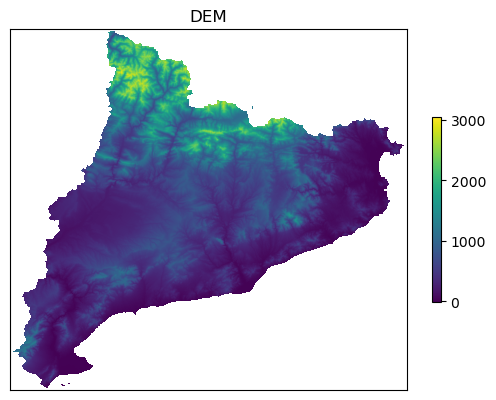

Calculating slope, aspect and roughness


Calculating northing and easting files
Reading aspect file dem_processing/aspect.tif
Aspect looks like this...


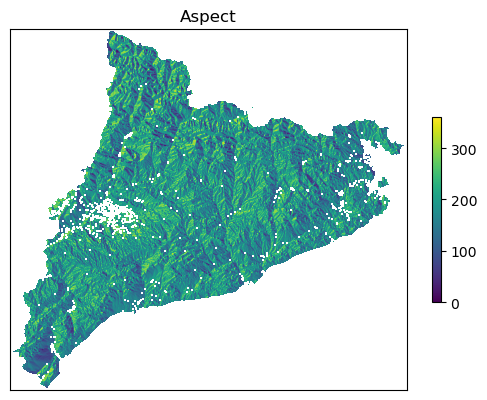

Saving northing file dem_processing/northing.tif
Saving easting file dem_processing/easting.tif


In [14]:
process_dem(dem_path_clip, dem_proc_path, verbose=True)

## Land cover data

The shape(rows-columns) of LC map is:  (2554, 2810) 
 Datatype is:  int16 
 The range of values are:  0 523
Values of LC codes are:  
 [  0 111 112 121 122 123 124 131 132 133 141 142 211 212 213 221 222 223
 231 241 242 243 311 312 313 321 322 323 324 331 332 333 334 335 411 421
 422 511 512 521 523]


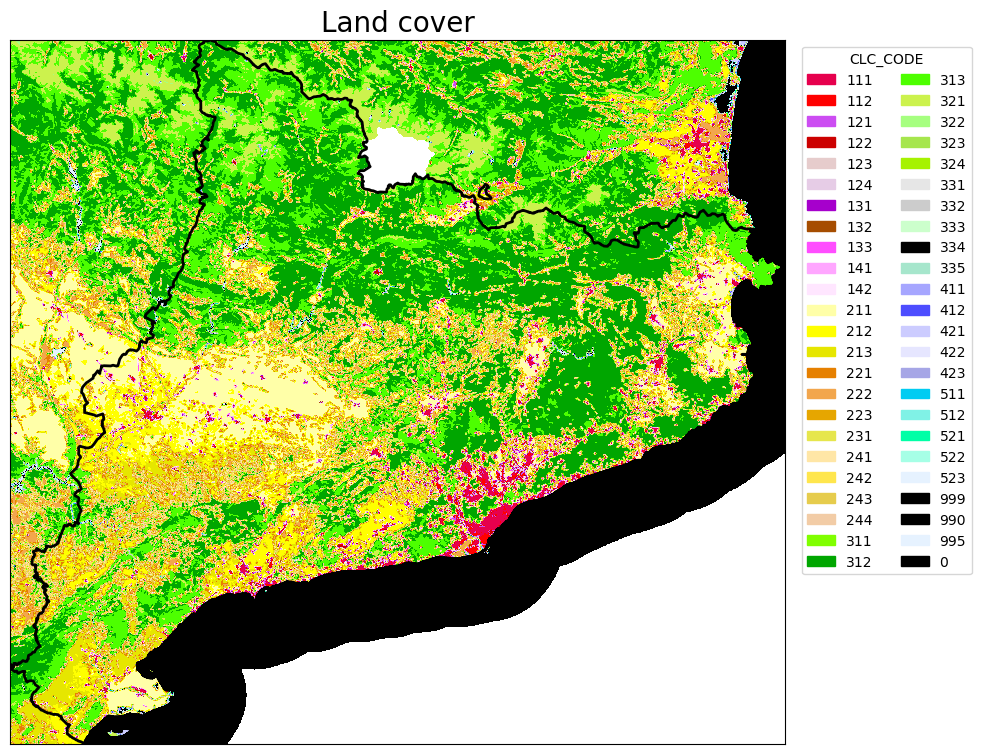

In [15]:
# Create an info dataframe on CLC land cover (DONE)
clc_leg = pd.read_excel(input_hazard_path / "clc2000legend.xls")

# Eliminate nans of the dataframe in column CLC_CODE, wioll put "0-0-0"
clc_leg["RGB"] = clc_leg["RGB"].fillna("0-0-0")

# Create dataframe with CLC_CODE, R, G, B (using split of RGB of clc_leg)
clc_leg["R"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[0]))
clc_leg["G"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[1]))
clc_leg["B"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[2]))

# I need to create a row for accouting for 0 values in the raster
clc_leg = pd.concat([clc_leg, pd.DataFrame({"CLC_CODE":0, "LABEL3":"No data/Not Burnable", "R":0, "G":0, "B":0}, index = [0])]).reset_index(drop = True)

# create a colormap for the land cover raster
clc_colormap = {}

# Create a colormap from the DataFrame
# For all clc codes
cmap = mcolors.ListedColormap(clc_leg[['R', 'G', 'B']].values/255.0, N=clc_leg['CLC_CODE'].nunique())
# For all clc codes except not burnable codes
cmap2 = mcolors.ListedColormap(clc_leg[['R', 'G', 'B']].values/255.0, N=clc_leg['CLC_CODE'].nunique() - 1)

# Create a list to hold the legend elements
legend_elements = []
# Iterate over the rows of the DataFrame
for _, row in clc_leg.iterrows():
    # Create a patch for each CLC code with the corresponding color and label
    color = (row['R']/255.0, row['G']/255.0, row['B']/255.0)
    #print(color)
    label = str(row['CLC_CODE'])
    #print(label)
    patch = mpatches.Patch(color=color, label=label)
    #print(patch)
    # Add the patch to the legend elements list
    legend_elements.append(patch)

# PLOT THE LAND COVER RASTER

# Open the raster data
raster_clc_clipped = input_hazard_path / "veg_corine_reclass_clip.tif"
with rasterio.open(raster_clc_clipped) as src:
    # Read the raster band
    band = src.read(1)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot the raster
    rasterio.plot.show(src, ax=ax, cmap = cmap)
    # Plot the shapefile
    region_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    # band is the raster data.  I want to know nrows, ncols, NODATA_value, dtype.
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1), title="CLC_CODE", ncols=2)
    ax.set_title("Land cover", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    print('The shape(rows-columns) of LC map is: ', band.shape,'\n','Datatype is: ', band.dtype,'\n', 'The range of values are: ' , band.min(),band.max())
    print('Values of LC codes are: ', '\n', np.unique(band))

Save the raster of clc with all non-burnable classes set to 0:

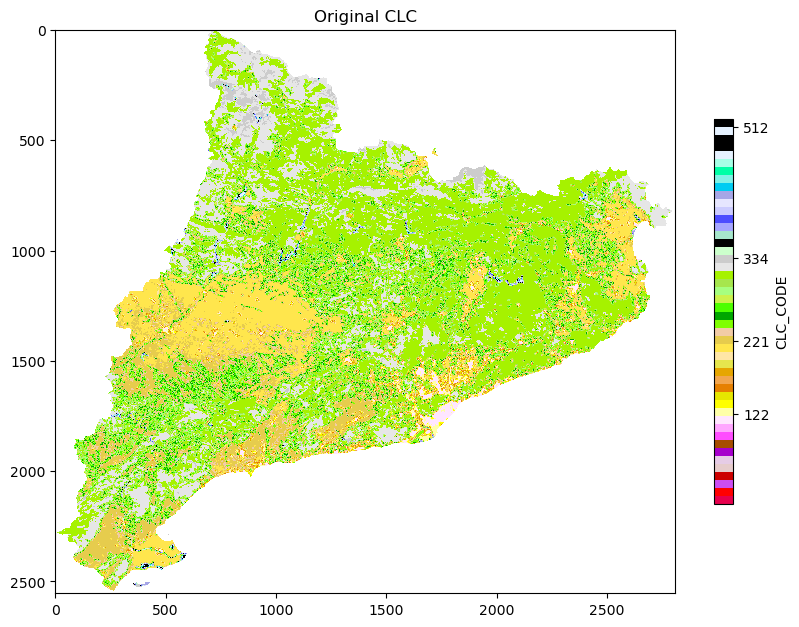

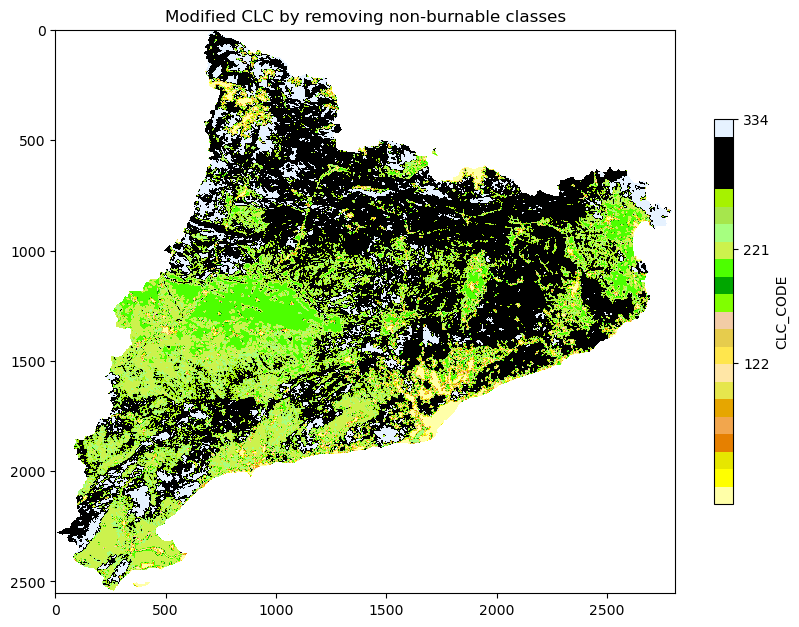

In [16]:
list_of_non_burnable_clc = [111,112,121,122,123,124,131,132,133,141,142,
                            331,332,333,335,411,412,421,422,423,511,512,521,522,523]

# Below, some considerations in the 3XX classes of the CLC and their degree of burnability.
# 331 332 333  are respectively beaches, dunes, sands; bare rocks; sparsely vegetated areas; in this case I will consider them as non-burnable
# 334 burnt areas in this case I will consider them as burnable
# 335 glaciers and perpetual snow in this case I will consider them as non-burnable

# Creating legends for newclc
burnables = set(clc_leg['CLC_CODE'].tolist()) - set(list_of_non_burnable_clc)
burnables = list(burnables)
cmap2_gdf = clc_leg.loc[:,['CLC_CODE','R', 'G', 'B']]
cmap2_gdf = cmap2_gdf[cmap2_gdf['CLC_CODE'].isin(burnables)]
cmap2 = mcolors.ListedColormap(cmap2_gdf[['R', 'G', 'B']].values/255.0, N=cmap2_gdf['CLC_CODE'].nunique()-1)

# Open the raster
output_clc_path = input_hazard_path / "veg_corine_reclass_clip_nb.tif"
ref = rasterio.open(reference_raster_path).read(1)
with rasterio.open(raster_clc_clipped) as src:
    # Read the raster band
    band = src.read(1)
    # First plot, left side of the multiplot
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot the raster
    plt.imshow(np.where(ref == -9999, np.nan, band), cmap = cmap)
    plt.title('Original CLC')
    plt.colorbar(shrink = 0.5, label = 'CLC_CODE', ticks = [122, 221, 334, 512])
    plt.show()
    # Set the values in list_of_non_burnable_clc to 0
    band[np.isin(band, list_of_non_burnable_clc)] = 0
    # Plot the raster, right side of the multiplot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.where(ref == -9999, np.nan, band), cmap = cmap2)
    plt.title('Modified CLC by removing non-burnable classes')
    plt.colorbar(shrink = 0.5, label = 'CLC_CODE', ticks = [122, 221, 334, 512])
    plt.show()
    # Save the modified raster
    with rasterio.open(output_clc_path, 'w', **src.profile) as dst:
        dst.write(band, 1)

## Cleaning Fire Data

Data cleaning of Catalan wildfires. Discard all rows whose `"YEAR_FIRE"` is not of 4 characters. How many are the rows discarded? The row discarded seem to be the overlapping fires... for this they have multiple date entries.

In [17]:
fires_path = input_hazard_path / "fires" / "Forest_Fire_1986_2022_filtrat_3035.shp"
fires = gpd.read_file(fires_path)
print("Number of rows...", len(fires))

rows_discarded = len(fires) - len(fires[fires['YEAR_FIRE'].str.len() == 4])
fires_2 = fires[fires['YEAR_FIRE'].str.len() == 4]
fires_0 = fires[fires['YEAR_FIRE'].str.len() != 4]
print("Number of rows discarded:", rows_discarded)
print("These are the buggy entries in the FIRE_YEAR column...",fires_0.YEAR_FIRE.unique())
print("......")
print("I will convert to int the YEAR_FIRE column of the non buggy data...")

#fires_2.loc['YEAR_FIRE'] = fires_2['YEAR_FIRE'].astype(int)
fires_2.loc[:, 'YEAR_FIRE'] = fires_2['YEAR_FIRE'].astype(int) # to avoid setting with copy warning
print("The filtered dataset comprises of ", len(fires_2), "rows, spanning the years" , fires_2.YEAR_FIRE.min(), "to", fires_2.YEAR_FIRE.max())

# in the following, fires_2 will be our geo dataframe with the fires.
# Now selecting just the fires_2 with year > 1990
fires_2 = fires_2[fires_2['YEAR_FIRE'] > 1990]
print("After the filtering the final filtered dataset comprises of ", len(fires_2), "rows, spanning the years" , fires_2.YEAR_FIRE.min(), "to", fires_2.YEAR_FIRE.max())

Number of rows... 1217
Number of rows discarded: 395
These are the buggy entries in the FIRE_YEAR column... ['Unknown' '1995 - 2015 - 2012' '1995 - 2015 - 2021' '1995 - 2012 - 2021'
 '1995 - 2006 - 2010' '1995 - 1999 - 2002' '1995 - 2000 - 2021'
 '1986 - 1995 - 2019' '1986 - 1998 - 2004' '1988 - 1993 - 2001'
 '1986 - 2011' '1986 - 2012' '1986 - 1997' '1986 - 1995' '1998 - 2020'
 '1986 - 1999 - 2012' '1986 - 2003 - 2012' '1986 - 2004 - 2012'
 '1986 - 2006 - 2012' '1986 - 2007 - 2012' '1989 - 1994' '1989 - 2003'
 '1989 - 2005' '1989 - 2020' '1989 - 2014' '1989 -2012' '1990 - 1994'
 '1995 - 2010' '1995 - 2017' '1986 - 2000 - 2021' '1986 - 2001 - 2003'
 '1986 - 2001 - 2022' '1986 - 2002 - 2022' '1988 - 2001' '1988 - 2003'
 '1988 - 2009' '1988 - 2012' '1988 - 1991' '1988 - 1994' '1988 - 2007'
 '1986 - 2016' '1986 - 2022' '1986 - 1994' '1986 - 2005' '1994 - 2003'
 '1994 - 2011' '1994 - 1987' '1990 - 2016' '1990 - 2020' '2005 - 2020'
 '2005 - 2013' '2006 - 2012' '1986 - 2004 - 2022' '1986 - 1

To avoid overfitting I am going to delete two big fires from the data set. They are located in the central part of Catalonia and they did not represent the classical fire regime in the region.
198969,0
199033,0

In [18]:
fires_2 = fires_2.loc[(fires_2['OBJECTID'] != 199033.0) & (fires_2['OBJECTID'] != 198969.0),:]

The geodataframe of the fires is rasterized and saved to file(raster), using the corine land cover raster as a reference.

In [19]:
# Rasterize the fires...
raster_clc_clipped = input_hazard_path / "veg_corine_reclass_clip.tif"
fires_rasterized = rasterize_numerical_feature(fires_2, raster_clc_clipped, column=None)
# save to file
save_raster_as(fires_rasterized, fires_raster_path, raster_clc_clipped)

Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2241986.65|
| 0.00, 0.00, 1.00|
Features.rasterize is launched...
Features.rasterize is done...


## Visualization

Check that the rasterized fires can assume just the values 0 and 1 and there are no nan values.

The values of fire rasterised file are:  [0. 1.]
There is a NaN in file:  False


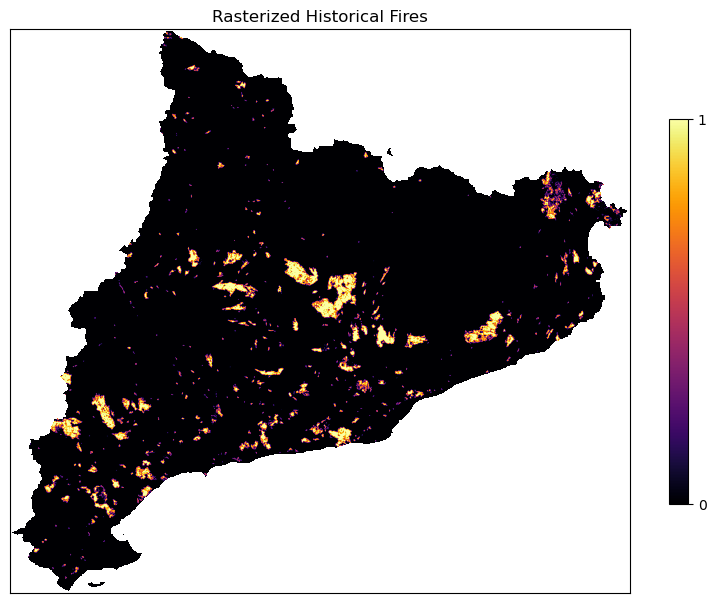

In [20]:
# Values of the rasterized fires
print('The values of fire rasterised file are: ', np.unique(fires_rasterized))

# Does the rasterized files have nan?
print('There is a NaN in file: ', np.isnan(fires_rasterized).any())

# Visualize the rasterized fires
fig, ax = plt.subplots(figsize=(10, 10))
cx = ax.imshow(np.where(ref == -9999, np.nan, fires_rasterized), cmap = 'inferno')
cbar = fig.colorbar(cx, ax =ax, shrink = 0.5, ticks = [0, 1])
ax.set_title('Rasterized Historical Fires')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Creating our model

A class is defined to handle the path and metadata of a raster:

In [21]:
class MyRaster:
    """
    dem_raster = MyRaster(dem_path, "dem")
    dem_raster.read_raster()
    slope_raster = MyRaster(slope_path, "slope")
    slope_raster.read_raster()
    northing_raster = MyRaster(aspect_path, "aspect")
    northing_raster.read_raster()
    easting_raster = MyRaster(easting_path, "easting")
    easting_raster.read_raster()
    roughness_raster = MyRaster(roughness_path, "roughness")
    dem_rasters = [dem_raster, slope_raster, northing_raster, easting_raster, roughness_raster]
    """
    def __init__(self, path, label):
        self.path = path
        self.label = label
        self.data = None
        self.mask = None
        self.nodata = None
        self.read_raster()

    def read_raster(self):
        with rasterio.open(self.path) as src:
            self.data = src.read(1, masked=True)
            self.mask = src.read_masks(1)
            self.nodata = src.nodata

    def set_data(self, data):
        self.data = data

    def get_data(self):
        return self.data

    def get_mask(self):
        return self.mask

    def get_nodata(self):
        return self.nodata

    def get_label(self):
        return self.label

    def get_path(self):
        return self.path

    def get_shape(self):
        return self.data.shape

    def get_transform(self):
        return self.transform

    def get_crs(self):
        return self.crs

    def get_bounds(self):
        return self.bounds

    def get_meta(self):
        return self.meta

    def get_height(self):
        return self.height

    def get_width(self):
        return self.width

    def get_dtype(self):
        return self.dtype

    def get_count(self):
        return self.count

    def get_index(self):
        return self.index

    def get_nodatavals(self):
        return self.nodatavals

Some functions are defined to assemble the dictionaries with the rasters to be used in the model:

In [22]:
def assemble_climate_dict(clim_category, clim_cat_namefile, clim_var_names):
    """
    Parameters
    ----------
    clim_category : string that can have the following values: "rcp45_2011_2020", "rcp45_2021_2040", "hist_1961_1990", "hist_1991_2010"
    clim_cat_namefile: string which classifies the filenames of the category (tipically the years)
        examples are: "201120", "202140", "196190", "199110"
    clim_var_names: a list of strings with the names of the climate variables to be used in the model. An example of such list is:
    ["MWMT", "TD", "AHM", "SHM", "DDbelow0", "DDabove18", "MAT", "MAP", "Tave_sm", "Tmax_sm", "PPT_at", "PPT_sm", "PPT_sp", "PPT_wt"]
    Returns: a dictionary with the climate variables as keys and the MyRaster objects as values
    sample usage:
    climate_dict = assemble_climate_dict("hist_1991_2010", "1991_2010", clim_var_names)
    future_climate_dict = assemble_climate_dict("rcp45_2021_2040", "202140", clim_var_names)
    """

    climate_paths = []
    for clim_var_name in clim_var_names:
        climate_paths.append(os.path.join(clim_category, clim_var_name + "_" + clim_cat_namefile + ".tif"))

    climate_dict = {}
    for path, label in zip(climate_paths, clim_var_names):
        climate_dict[label] = MyRaster(path, label)
        climate_dict[label].read_raster()
    return climate_dict


def assemble_dem_dict(dem_paths, dem_labels):
    """Assemble the dictionary with all the rasters to be used in the model which are related to topography.
    
    :param dem_paths: paths to the dem and related rasters
    :param dem_labels: labels of the dem and related rasters
    :return: a dictionary with all the rasters to be used in the model
    usage example:
    dem_paths = [dem_path, slope_path, aspect_path, easting_path, northing_path, roughness_path]
    dem_labels = ["dem", "slope", "aspect", "easting", "northing", "roughness"]
    dem_dict = assemble_dem_dict(dem_paths, dem_labels)
    """
    # Create the dictionary
    dem_dict = {}
    for path, label in zip(dem_paths, dem_labels):
        dem_dict[label] = MyRaster(path, label)
        dem_dict[label].read_raster()

    return dem_dict


def assemble_veg_dictionary(veg_path, dem_path, verbose=False):
    """Assemble the dictionary with all the rasters to be used in the model which are related to vegetation.
    
    This comprises of:
    - the vegetation raster
    - the rasters of vegetation densities: a fuzzy counting of the neighboring vegetation for each type of vegetation
        See Tonini et al. 2020 for more details.

    :param veg_path: path to the vegetation raster.
    :return: a dictionary with all the veg rasters to be used in the model
    
    usage example:
    veg_dict = assemble_veg_dictionary(veg_path, dem_path, verbose = True)
    """
    # Create the dictionary
    veg_dict = {}
    veg_dict["veg"] = MyRaster(veg_path, "veg")
    veg_dict["veg"].read_raster()
    veg_arr = veg_dict["veg"].data.astype(int)
    dem_raster = MyRaster(dem_path, "dem")
    dem_raster.read_raster()
    dem_arr = dem_raster.data
    dem_nodata = dem_raster.nodata

    veg_mask = np.where(veg_arr == 0, 0, 1)
    # complete the mask selecting the points where also dem exists.
    mask = (veg_mask == 1) & (dem_arr != dem_nodata)

    # evaluation of perc just in vegetated area, non vegetated are grouped in code 0
    veg_int = veg_arr.astype(int)
    veg_int = np.where(mask == 1, veg_int, 0)
    window_size = 2
    types = np.unique(veg_int)
    if verbose:
        print("types of vegetation in the veg raster:", types)
    types_presence = {}

    counter = np.ones((window_size*2+1, window_size*2+1))
    take_center = 1
    counter[window_size, window_size] = take_center
    counter = counter / np.sum(counter)

    # perc --> neighbouring vegetation generation
    for t in tqdm(types, desc="processing vegetation density"):
        density_entry = 'perc_' + str(int(t))
        if verbose:
            print(f'Processing vegetation density {density_entry}')
        temp_data = 100 * signal.convolve2d(veg_int==t, counter, boundary='fill', mode='same')
        temp_raster = MyRaster(dem_path, density_entry) # the path is dummy... I need just the other metadata.
        temp_raster.read_raster()
        temp_raster.set_data(temp_data)
        veg_dict[density_entry] = temp_raster

    return veg_dict, mask


def preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask, verbose=True):
    """
    Usage:
    X_all, Y_all, columns = preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask)
    """
    # creaate X and Y datasets
    n_pixels = len(dem_dict["dem"].data[mask])

    # the number of features is given by all the dem layers, all the veg layers, all the climate layers.
    # TODO: add the possibility to add other layers which belong to a "misc" category.
    n_features = len(dem_dict.keys())+ len(veg_dict.keys()) + len(climate_dict.keys())
    #create the dictionary with all the data
    data_dict = {**dem_dict, **veg_dict, **climate_dict}

    X_all = np.zeros((n_pixels, n_features), dtype=np.float32) # This is going to be big... Maybe use dask?
    Y_all = fires_raster.data[mask]

    if verbose:
        print('Creating dataset for RandomForestClassifier')
    columns = data_dict.keys()
    for col, k in tqdm(enumerate(data_dict), "processing columns"):
        if verbose:
            print(f'Processing column: {k}')
        data = data_dict[k]
        # data is a MyRaster object and data.data is the numpy array with the data
        X_all[:, col] = data.data[mask]

    return X_all, Y_all, columns


def prepare_sample(X_all, Y_all, percentage=0.1):
    """
    Usage:
    model, X_train, X_test, y_train, y_test = train(X_all, Y_all, percentage)
    
    parameters:
    X_all: the X dataset with the descriptive features
    Y_all: the Y dataset with the target variable (burned or not burned)
    percentage: the percentage of the dataset to be used for training
    """
    # randomforest parameters
    max_depth = 10
    number_of_trees = 100
    # filter df taking info in the burned points
    fires_rows = Y_all.data != 0
    print(f'Number of burned points: {np.sum(fires_rows)}')
    X_presence = X_all[fires_rows]

    # sampling training set
    print(' I am random sampling the dataset ')
    # reduction of burned points --> reduction of training points
    reduction = int((X_presence.shape[0]*percentage))
    print(f"reducted df points: {reduction} of {X_presence.shape[0]}")

    # sampling and update presences
    X_presence_indexes = np.random.choice(X_presence.shape[0], size=reduction, replace=False)

    X_presence = X_presence[X_presence_indexes, :]
    # select not burned points

    X_absence = X_all[~fires_rows] #why it is zero?
    print("X_absence.shape[0]", X_absence.shape[0])
    print("X_presence.shape[0]", X_presence.shape[0])
    X_absence_choices_indexes = np.random.choice(X_absence.shape[0], size=X_presence.shape[0], replace=False)

    X_pseudo_absence = X_absence[X_absence_choices_indexes, :]
    # create X and Y with same number of burned and not burned points
    X = np.concatenate([X_presence, X_pseudo_absence], axis=0)
    Y = np.concatenate([np.ones((X_presence.shape[0],)), np.zeros((X_presence.shape[0],))])
    # create training and testing df with random sampling
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

    print(f'Running RF on data sample: {X_train.shape}')
    model  = RandomForestClassifier(n_estimators=number_of_trees, max_depth = max_depth, verbose = 2)

    return model, X_train, X_test, y_train, y_test


def fit_and_print_stats(model, X_train, y_train, X_test, y_test, columns):
    """Fit the model and prints the stats on the training and test datasets.
    
    Input:
    model: the model to fit
    X_train: the training dataset
    y_train: the training labels
    X_test: the test dataset
    y_test: the test labels
    columns: the columns of the dataset (list of strings that were the keys of the dictionary)
    
    example usage:
    fit_and_print_stats(model, X_train, y_train, X_test, y_test, columns)
    """
    # fit model
    model.fit(X_train, y_train)
    # stats on training df
    p_train = model.predict_proba(X_train)[:,1]

    auc_train = sklearn.metrics.roc_auc_score(y_train, p_train)
    print(f'AUC score on train: {auc_train:.2f}')

    # stats on test df
    p_test = model.predict_proba(X_test)[:,1]
    auc_test = sklearn.metrics.roc_auc_score(y_test, p_test)
    print(f'AUC score on test: {auc_test:.2f}')
    mse = sklearn.metrics.mean_squared_error(y_test, p_test)
    print(f'MSE: {mse:.2f}')
    p_test_binary = model.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, p_test_binary)
    print(f'accuracy: {accuracy:.2f}')

    # features impotance
    print('I am evaluating features importance')
    imp = model.feature_importances_

    perc_imp_list = list()
    list_imp_noPerc = list()

    # separate the perc featuers with the others
    for i,j in zip(columns, imp):
        if i.startswith('perc_'):
            perc_imp_list.append(j)
        else:
            list_imp_noPerc.append(j)

    # aggregate perc importances
    perc_imp = sum(perc_imp_list)
    # add the aggregated result
    list_imp_noPerc.append(perc_imp)

    # list of columns of interest
    cols = [col for col in columns if not col.startswith('perc_')]
    cols.append('perc')

    # print results
    print('importances')
    dict_imp = dict(zip(cols, list_imp_noPerc))
    dict_imp_sorted = {k: v for k, v in sorted(dict_imp.items(),
                                                key=lambda item: item[1],
                                                reverse=True)}
    for i in dict_imp_sorted:
        print('{} : {}'.format(i, round(dict_imp_sorted[i], 2)))


def get_results(model, X_all, full_shape, mask):
    """Get the results of the model and returns a raster with the results
    
    Input:
    model: the model to fit
    X_all: the dataset with the descriptive features
    dem_arr: the dem array data
    mask: the mask of the dem array with all the valid and burnable pixels
    
    example usage:
    Y_raster = get_results( model, X_all,dem_arr, mask)
    """
    # prediction over all the points
    Y_out = model.predict_proba(X_all)
    # array of predictions over the valid pixels
    Y_raster = np.zeros(full_shape)
    Y_raster[mask] = Y_out[:,1]
    # clip susc where dem exsits
    Y_raster[~mask] = -1
    return Y_raster

### Training the model

using the previously defined functions:

In [23]:
def make_model(res_path, period, verbose=False):
    # Climate model input fields
    climate_dict = assemble_climate_dict(res_path, period, var_names)
    # DEM input fields
    dem_dict = assemble_dem_dict(
        [dem_path_clip, slope_path, aspect_path, easting_path, northing_path, roughness_path],
        ["dem", "slope", "aspect", "easting", "northing", "roughness"]
    )
    # Vegetation input fields
    veg_dict, mask = assemble_veg_dictionary(clc_path_clip_nb, dem_path_clip, verbose=verbose)
    # Fire data not needed for running the model, but define output shape
    fires_raster = MyRaster(fires_raster_path, "fires")
    # Preprocess and assemble training dataset
    X_all, Y_all, columns = preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask, verbose=verbose)
    # Prepare for model training
    model, X_train, X_test, y_train, y_test = prepare_sample(X_all, Y_all, percentage=0.1)
    # Train the model
    fit_and_print_stats(model, X_train, y_train, X_test, y_test, columns)
    # Return the trained model
    return model

In [24]:
model = make_model(res_hist_path, hist_period)

processing vegetation density: 100%|██████████| 19/19 [00:13<00:00,  1.39it/s]
processing columns: 40it [00:03, 11.20it/s]


Number of burned points: 152232
 I am random sampling the dataset 
reducted df points: 15223 of 152232
X_absence.shape[0] 7024508
X_presence.shape[0] 15223
Running RF on data sample: (20398, 40)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 10

### Running the model for the historical climate

Apply the model to the historical (training) data and compute susceptibility.

In [25]:
def run_model(model, res_path, period, verbose=False):
    # Climate model input fields
    climate_dict = assemble_climate_dict(res_path, period, var_names)
    # DEM input fields
    dem_dict = assemble_dem_dict(
        [dem_path_clip, slope_path, aspect_path, easting_path, northing_path, roughness_path],
        ["dem", "slope", "aspect", "easting", "northing", "roughness"]
    )
    # Vegetation input fields
    veg_dict, mask = assemble_veg_dictionary(clc_path_clip_nb, dem_path_clip, verbose=verbose)
    # Fire data not needed for running the model, but define output shape
    fires_raster = MyRaster(fires_raster_path, "fires")
    # Preprocess and assemble input data for the ML model
    X_all, _, _ = preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask, verbose=verbose)
    # Evaluate the model and return results
    return get_results(model, X_all, fires_raster.data.shape, mask)

In [26]:
Y_raster = run_model(model, res_hist_path, hist_period)

processing vegetation density: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]
processing columns: 40it [00:03, 10.75it/s]
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.6s


Convert results array to a raster and save to a file:

In [27]:
output_suscep_hist = output_hazard_path / f"suscep_hist_{hist_period}.tif"

save_raster_as(Y_raster, output_suscep_hist, dem_path_clip)

I want to extract the 50, 75, 90, 95 quantiles of `Y_raster[Y_raster>=0.0]`. Since the susceptibility is the output of a random forest classifier with `proba = True`, its outputs are distributed between 0 and 1. I need to extract the quantiles of the positive values only, in order to get meaningful data from the arbitrary decisions of the classifier.

In [28]:
print(
    'Min susc is: ', Y_raster[Y_raster>=0.0].min(), '\n'
    'Max susc is: ', Y_raster[Y_raster>=0.0].max(), '\n'
    'Mean susc is: ', Y_raster[Y_raster>=0.0].mean(), '\n'
    'Standard deviation is:', Y_raster[Y_raster>=0.0].std(), '\n\n'
    'q1:', np.quantile(Y_raster[Y_raster>=0.0], 0.5), '\n'
    'q2:', np.quantile(Y_raster[Y_raster>=0.0], 0.75), '\n'
    'q3:', np.quantile(Y_raster[Y_raster>=0.0], 0.9), '\n'
    'q4:', np.quantile(Y_raster[Y_raster>=0.0], 0.95)
)

Min susc is:  0.0 
Max susc is:  0.9993333333333334 
Mean susc is:  0.1827145475758616 
Standard deviation is: 0.2823722848209225 

q1: 0.0006623221034386723 
q2: 0.2948623161575272 
q3: 0.6825798641180404 
q4: 0.8026208292883305


### Visualizing the historical susceptibility

Plot the susceptibility for the present climate:

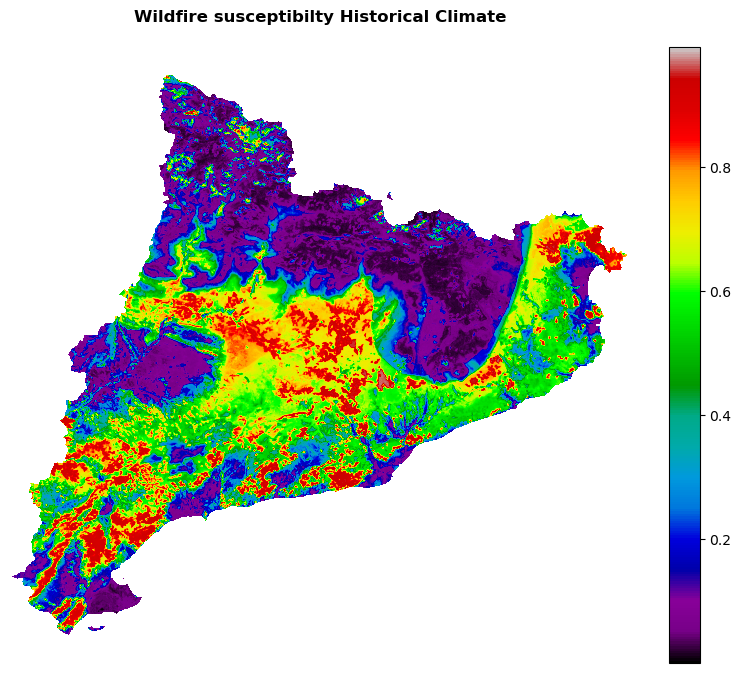

In [29]:
with rasterio.open(output_suscep_hist) as src:
    band = src.read(1)
    plot_raster_V2(band, ref, cmap='nipy_spectral', title=f"Wildfire susceptibilty Historical Climate", dpi=100)

## Future climate data

The authors of the ECLIPS2.0 dataset (Chakraborty et al., 2021) used five daily bias-corrected regional climate model results out of nine projections available in the EURO-CORDEX database at the time of this study.
The criteria used to select the five climate projections were as follows:

1. representation of all available RCMs and GCMs;
2. two RCMs being nested in the same driving GCM; and
3. one RCM being driven by two different GCMs.

Such criteria were adopted to ensure the representativeness of all combinations of RCMs and GCMs available in the EURO-CORDEX database.
The models were driven by two Representative Concentration Pathways scenarios RCP4.5 and RCP8.5 (Moss et al., 2010).
The simulations were run for the EUR-11 domain with 0.11° × 0.11° horizontal resolution (Giorgi et al., 2009; Jacob et al., 2014). 

### Future scenario and period and climate model selection

Choose:

1.  A representative concentration pathway scenario from the ECLIPS-2.0 dataset:

    - RCP 4.5 (`"RCP45"`)
    - RCP 8.5 (`"RCP85"`)

2.  A climate model data source (the regional climate model (RCM) is nested in the driving global climate model (GCM)):

    - `"CLMcom_CCLM"`: Climate Limited-Area Modelling Community, CLMcom-CLM4-8-17 (RCM), CNRM-CERFACS-CNRM-CM5 (GCM).
    - `"CLMcom_CLM"`: Climate Limited-Area Modelling Community, CLMcom-CLM4-8-17 (RCM), MPI-M-MPI-ESM-LR (GCM).
    - `"DMI_HIRAM"`: Danish Meteorological Institute, DMI-HIRHAM5 (RCM), ICHEC-EC-EARTH (GCM).
    - `"KNMI_RAMCO"`: Royal Netherlands Meteorological Institute, KNMI- RACMO22E (RCM), MOHC-HadGEM2-ES (GCM).
    - `"MPI_CSC_REMO2009"`: Max Planck Institute for Meteorology.MPI-CSC-REMO2009 (RCM), MPI-M-MPI-ESM-LR (GCM).

3.  A time period to run the machine learning model for:

    - 2011 to 2020 (`"201120"`)
    - 2021 to 2040 (`"202140"`)
    - 2041 to 2060 (`"204160"`)
    - 2061 to 2080 (`"206180"`)
  

:::{tip}
You can return to this point of the workflow and rerun the following cells for different combinations of RCP scenario, climate model and time period without having to train the machine learning model again (as long as you don't restart the Jupyter kernel).
:::

In [30]:
future_scenario = "RCP85"
climate_model = "CLMcom_CCLM"
future_period = "204160"

# Create a unique identifier from the selected combination for filenames
future_config_id = f"{future_scenario}_{climate_model}_{future_period}"

### Climate model data for chosen configuration

Generate paths for chosen scenario, period and model configuration:

In [31]:
# Path to data for selected scenario and model in ECLIPS dataset
model_path = ECLIPS2p0_path / f"ECLIPS2.0_{future_scenario}" / f"{climate_model}_{future_scenario[3:-1]}.{future_scenario[-1]}"
# Filenames for selected future period
future_files = [model_path / f"{vv}_{future_period}.tif" for vv in var_names]

Download the input fields for the machine learning model for the specified configuration of scenario, climate model and future period from the [CLIMAAX ECLIPS2.0 dataset mirror](https://handbook.climaax.eu/resources/datasets/eclips2.0_mirror.html) with pooch.

:::{note}
If you started with the provided Catalonia sample dataset (Option A) or downloaded the full ECLIPS2.0 dataset (Option C) at the beginning, you can skip the next cell.
:::

In [ ]:
for file in future_files:
    file_rel = file.relative_to(eclips_mirror_pooch.path)
    eclips_mirror_pooch.fetch(str(file_rel))

### Resize climate model data

Extract the selected region and reproject the input data.

In [33]:
# Output path for resized raster files
res_future_path = res_clim_dir_path / future_config_id

:::{note}
If you started with the Catalonia sample data, you can skip the next cell.
The rasters in the sample data are already resized.
:::

In [34]:
future_files_res = resize_rasters_gdalwarp(future_files, res_future_path)
check_resized_rasters(future_files_res, reference_raster_path)

100%|██████████| 14/14 [00:00<00:00, 196.00it/s]

MWMT_204160.tif has the same dimensions as the reference raster.
TD_204160.tif has the same dimensions as the reference raster.
AHM_204160.tif has the same dimensions as the reference raster.
SHM_204160.tif has the same dimensions as the reference raster.
DDbelow0_204160.tif has the same dimensions as the reference raster.
DDabove18_204160.tif has the same dimensions as the reference raster.
MAT_204160.tif has the same dimensions as the reference raster.
MAP_204160.tif has the same dimensions as the reference raster.
Tave_sm_204160.tif has the same dimensions as the reference raster.
Tmax_sm_204160.tif has the same dimensions as the reference raster.
PPT_at_204160.tif has the same dimensions as the reference raster.
PPT_sm_204160.tif has the same dimensions as the reference raster.
PPT_sp_204160.tif has the same dimensions as the reference raster.
PPT_wt_204160.tif has the same dimensions as the reference raster.


### Run the model on future data

To project the model in the future, we need to repeat the same steps as above, but with the future climate data.
The DEM will be the same, and vegetation will be the same (in that case, it is a simplification, but it is ok for now).

In [35]:
Y_raster_future = run_model(model, res_future_path, future_period)

processing vegetation density: 100%|██████████| 19/19 [00:13<00:00,  1.37it/s]
processing columns: 40it [00:04,  9.42it/s]
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.6s


### Visualizing the future susceptibility

Write the susceptibilty for the future climate:

In [36]:
output_suscep_future = output_hazard_path / f"suscep_{future_config_id}.tif"
save_raster_as(Y_raster_future, output_suscep_future, dem_path_clip)

Visualization of future susceptibility:

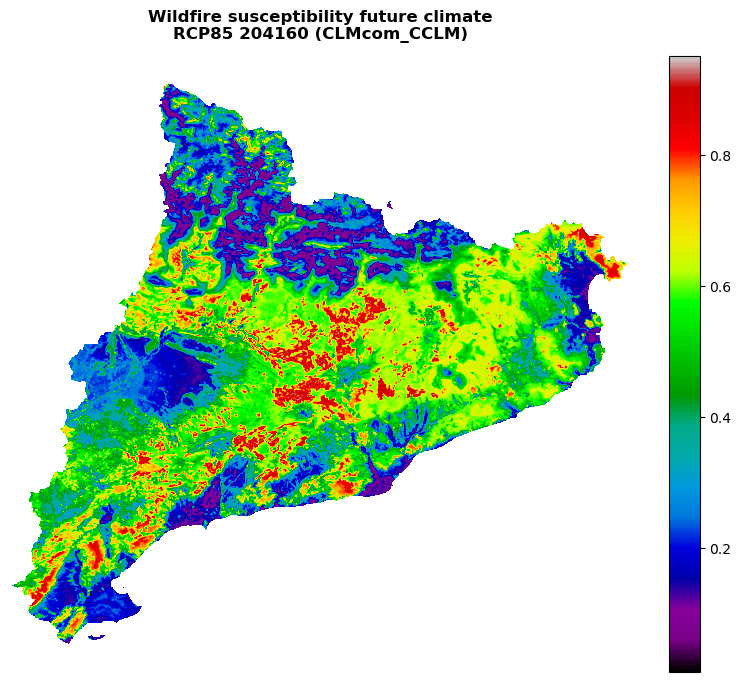

In [37]:
with rasterio.open(output_suscep_future) as src:
    band = src.read(1)
    plot_raster_V2(
        band,
        ref,
        cmap='nipy_spectral',
        title=(
            "Wildfire susceptibility future climate\n"
            f"{future_scenario} {future_period} ({climate_model})"
        ),
        dpi=100
    )

## Hazard

Functions to define the hazard:

In [38]:
def corine_to_fuel_type(corine_codes_array, converter_dict, visualize_result = False):
    """Convert the corine land cover raster to a raster with the fuel types.
    
    The fuel types are defined in the converter_dict dictionary.
    """
    converted_band = np.vectorize(converter_dict.get)(corine_codes_array)
    converted_band[converted_band == None] = -1
    #convert to int
    converted_band = converted_band.astype(int)
    if visualize_result:
        plt.matshow(converted_band)
        # discrete colorbar
        cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4, 5, 6])
    return converted_band


def susc_classes( susc_arr, quantiles):
    '''Take a raster map and a list of quantiles and returns a categorical raster map related to the quantile classes.
    
    Parameters:
    susc_arr: the susceptibility array
    quantiles: the quantiles to use to create the classes (see np.digitize documentation)
    '''
    bounds = list(quantiles)
    # Convert the raster map into a categorical map based on quantile values
    out_arr = np.digitize(susc_arr, bounds, right=True)
    out_arr = out_arr.astype(np.int8())
    return out_arr


def hazard_matrix(arr1, arr2):
    '''Takes two arrays and returns a matrix with the hazard values.
    
    arr1 take values on the rows -> susc., arr2 on the columns -> intensity
    
    Parameters:
    arr1: the susceptibility array
    arr2: the intensity array
    #   s\i  1 2 3 4
    #     1! 1 2 3 4
    #     2! 2 3 4 5
    #     3! 3 3 5 6
    '''
    matrix_values = np.array([
                            [1, 2, 3, 4],
                            [2, 3, 4, 5],
                            [3, 3, 5, 6]])
    # using fancy indexing
    combined_array = matrix_values[arr1 - 1, arr2 - 1]
    return combined_array


def contigency_matrix_on_array(xarr, yarr, xymatrix, nodatax, nodatay):
        '''
        xarr: 2D array, rows entry of contingency matrix
        yarr: 2D array, cols entry of contingency matrix
        xymatrix: 2D array, contingency matrix
        nodatax1: value for no data in xarr : if your array has nodata = np.nan >> nodatax or nodatay has to be 1
        nodatax2: value for no data in yarr : if your array has nodata = np.nan >> nodatax or nodatay has to be 1
        '''
        # if arr have nan, mask it with lowest class
        xarr = np.where(np.isnan(xarr)==True , 1, xarr)
        yarr = np.where(np.isnan(yarr)==True , 1, yarr)
        # convert to int
        xarr = xarr.astype(int)
        yarr = yarr.astype(int)

        mask = np.where(((xarr == nodatax) | (yarr ==nodatay)), 0, 1)

        # put lowest class in place of no data
        yarr[~mask] = 1
        xarr[~mask] = 1

        # apply contingency matrix
        output = xymatrix[ xarr - 1, yarr - 1]
        # mask out no data
        output[~mask] = 0
        return output

Create the intensity matrix by converting the CLC raster:

In [39]:
my_clc_raster = MyRaster(clc_path_clip_nb, "clc")

converter = pd.read_excel("./CORINE_to_FuelType.xlsx")
converter_dict = dict(zip(converter.veg.values, converter.aggr.values))

# I obtain the array of the fuel types converting the corine land cover raster
converted_band = corine_to_fuel_type(my_clc_raster.data.data, converter_dict)

# dtype of the converted band
print('data type is: ', converted_band.dtype)
print('values of original map(here corine) are:','\n', np.unique(converter_dict.keys()))
print('Values of fuel map are:','\n', converter_dict.values())

data type is:  int64
values of original map(here corine) are: 
 [dict_keys([111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142, 211, 212, 213, 221, 222, 223, 224, 231, 241, 242, 243, 244, 311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335, 411, 412, 421, 422, 423, 511, 512, 521, 522, 523, 999])]
Values of fuel map are: 
 dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 4, 4, 1, 3, 3, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Obtain the hazard map for present climate crossing the susceptibility map with the intensity map:

In [40]:
output_hazard_hist = output_hazard_path / f"hazard_{hist_config_id}.tif"
output_hazard_future = output_hazard_path / f"hazard_{future_config_id}.tif"

In [41]:
# compute quantiles for Y_raster
quantiles = np.quantile(Y_raster[Y_raster>=0.0], [0.5, 0.75 ])
print('quantiles are: ', quantiles)

# compute discrete susc array
susc_arr = susc_classes(Y_raster, quantiles) + 1 # >>>>>>>>>> I add 1 to avoid 0 values
print("Now I have just the susc classes", np.unique(susc_arr))

matrix_values = np.array([[1, 2, 3, 4],
                          [2, 3, 4, 5],
                          [3, 3, 5, 6]])

# Compute discrete hazard
hazard_arr = contigency_matrix_on_array(susc_arr, converted_band, matrix_values, 0 ,-1)

# Future
Y_raster_future = MyRaster(output_suscep_future, "susc_202140").data
# Compute susceptibility discrete array for future
susc_arr_future = susc_classes(Y_raster_future, quantiles) + 1 # I add 1 to avoid 0 values
# Compute hazard discrete array for future
hazard_arr_future = contigency_matrix_on_array(susc_arr_future, converted_band, matrix_values, 0, -1)

# Save the hazard arrays to file (raster)
save_raster_as_h(hazard_arr, output_hazard_hist, clc_path_clip_nb)
save_raster_as_h(hazard_arr_future, output_hazard_future, clc_path_clip_nb)

quantiles are:  [0.00066232 0.29486232]
Now I have just the susc classes [1 2 3]


Visualize the future and historical hazard classes:

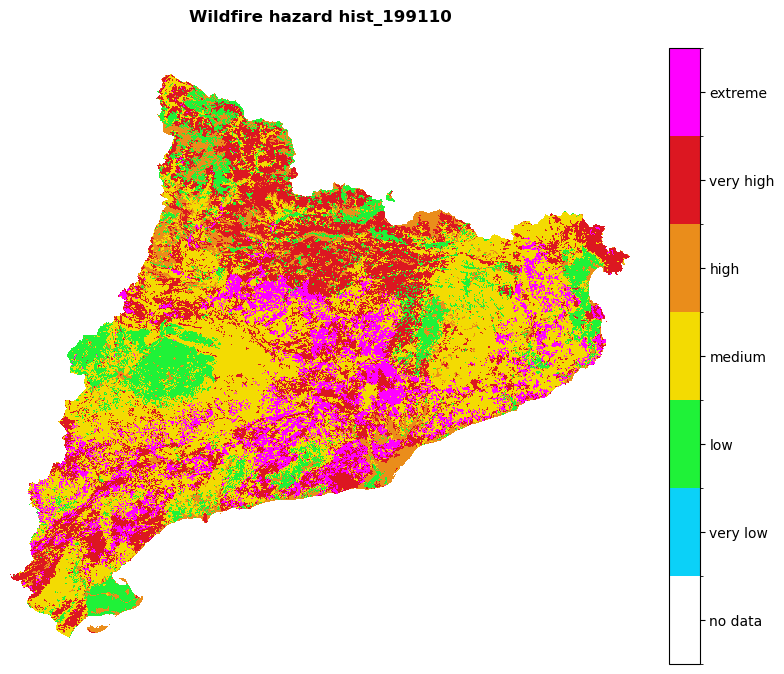

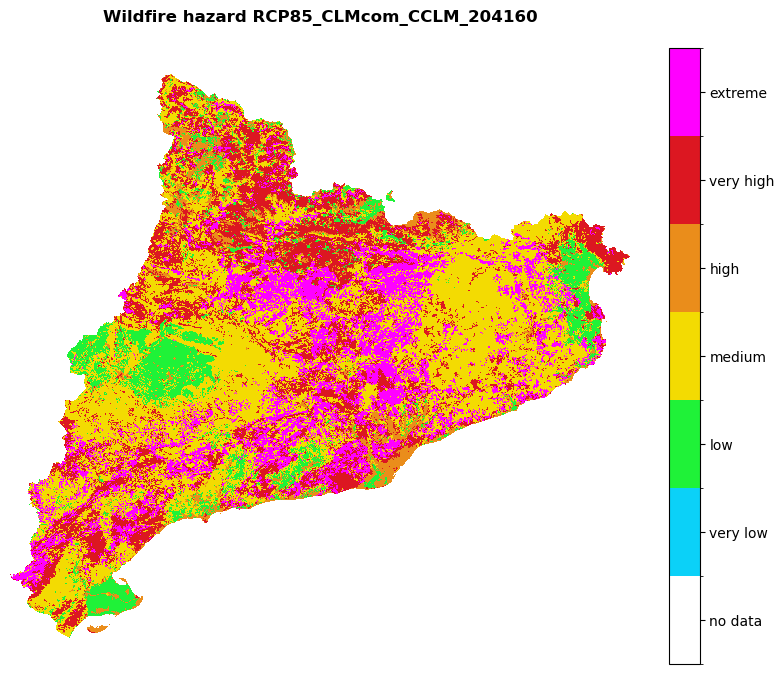

In [42]:
# hazard cmap
values = [0, 0.9, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1]
colors_ = ['#00000000', '#0bd1f8', '#1ff238', '#f3db02', '#ea8d1b', '#dc1721', '#ff00ff']
dict_haz_col = {0: '#00000000', 1: '#0bd1f8', 2: '#1ff238', 3: '#f3db02', 4: '#ea8d1b', 5: '#dc1721', 6: '#ff00ff'}

# Create colormap
cmap = mcolors.ListedColormap(colors, N=len(values))
norm = mcolors.BoundaryNorm(values, len(values))

region_gdf.to_crs(epsg=3035, inplace=True)

# Loop over hazard paths and plot
for hazard_path in [output_hazard_hist, output_hazard_future]:
    haz_arr = rasterio.open(hazard_path).read(1)
    name = os.path.basename(hazard_path).split('hazard_')[-1].split('.tif')[0]
    plot_raster_V2(
        haz_arr,
        ref,
        array_classes=values,
        classes_colors=colors_,
        classes_names=['no data', 'very low', 'low', 'medium', 'high', 'very high', 'extreme'],
        title=f'Wildfire hazard {name}',
        dpi=100
    )

## References

- Tonini, M.; D’Andrea, M.; Biondi, G.; Degli Esposti, S.; Trucchia, A.; Fiorucci, P. (2020): A Machine Learning-Based Approach for Wildfire Susceptibility Mapping. The Case Study of the Liguria Region in Italy. Geosciences 2020, 10, 105. DOI: [10.3390/geosciences10030105](https://doi.org/10.3390/geosciences10030105)

- Trucchia, A.; Meschi, G.; Fiorucci, P.; Gollini, A.; Negro, D. (2022): Defining Wildfire Susceptibility Maps in Italy for Understanding Seasonal Wildfire Regimes at the National Level. Fire 2022, 5, 30. DOI: [10.1071/WF22138](https://doi.org/10.3390/fire5010030)

- Trucchia, A.; Meschi, G.; Fiorucci, P.; Provenzale, A.; Tonini, M.; Pernice, U. (2023): Wildfire hazard mapping in the eastern Mediterranean landscape. International Journal of Wildland Fire 2023, 32, 417-434. DOI: [10.1071/WF22138](https://doi.org/10.1071/WF22138)

- Chakraborty, D.; Dobor, L.; Zolles, A.;, Hlásny, T.; Schueler, S. (2021): High-resolution gridded climate data for Europe based on bias-corrected EURO-CORDEX: The ECLIPS dataset.
 *Geoscience Data Journal*, 2021;8:121–131. DOI: [10.1002/gdj3.110](https://doi.org/10.1002/gdj3.110)

- Chakraborty D.; Dobor L.; Zolles A.; Hlásny T.; Schueler S. (2020): High-resolution gridded climate data for Europe based on bias-corrected EURO-CORDEX: the ECLIPS-2.0 dataset [Data set]. Zenodo. DOI: [10.5281/zenodo.3952159](https://doi.org/10.5281/zenodo.3952159)